# Fashion_MNIST_dataset

## About the Problem

This task is about *Image Classification* problem. Here, I have used **Pytorch** and **Logistic regression** technique to solve this Problem.

## Dataset
The dataset used here is the Fashion_MNSIT datset. This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images.

Here The classes are labeled as:

|Label|Description|
| :---------------| :----:|
|0|T-shirt/top|
|1|Trouser|
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneaker|
|8|Bag|
|9|Ankle boot|


## Importing libraries

Importing torch and torchvision. torchvision contains some utilities for working with image data. It also provides helper classes to download and import popular datasets like MNIST automatically

In [1]:
import torch
import torchvision
from torchvision.datasets import FashionMNIST

## Loading the datset

In [2]:
# Download training dataset
dataset = FashionMNIST(root='data/', download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
# Load test dataset
test_dataset = FashionMNIST(root='data/', train=False)

Checking the size of the dataset

In [4]:
print(len(dataset))
print(len(test_dataset))

60000
10000


Importing *matplotlib*, It is used to plote images.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

A sample element from the training dataset.

In [6]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 9)

Ploting a sample image with its label

Label: 9


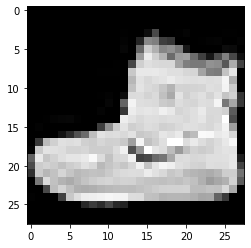

In [7]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Importing *torchvision.transforms* module, which will be used to convert this image format into *Tensors*.

In [8]:
import torchvision.transforms as transforms

Converting to Tensor

In [9]:
# FashionMNIST dataset (images and labels)
dataset = FashionMNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [10]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 9


The image is now converted to a 1x28x28 tensor.

## Training and Validation Datasets

Spliting the dataset using *random_split*

In [11]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

Using data loaders to load the data in batches. I have used a batch size of 128.

In [12]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

## Model

Using *nn.Linear* to create the model
*nn.Linear* expects each training example to be a vector, each 1x28x28 image tensor is flattened into a vector of size 784 (28*28) before being passed into the model.

In [13]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

Importing *torch.nn.functional* package to be later used during cross-entropy.

In [14]:
import torch.nn.functional as F

Defining function to calculate *Accuracy*.

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

## Training the model

Defining the function *fit*, which will be used to train the model.

In [16]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

defining the *evaluate* function, used in the validation phase of *fit*.

In [17]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

Defining the *MnistModel* class to include additional methods *training_step, validation_step, validation_epoch_end*, and *epoch_end* used by *fit* and *evaluate*.

In [18]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

## Evaluation

Before training the model, checking how the model performs on the validation set with the initial set of randomly initialized weights & biases.

In [19]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.454578161239624, 'val_acc': 0.016613924875855446}

Now ready to train the model. every time training for five epochs for fatser calculation. Also, printing the results.

In [20]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7652, val_acc: 0.5981
Epoch [1], val_loss: 1.4519, val_acc: 0.6493
Epoch [2], val_loss: 1.2723, val_acc: 0.6728
Epoch [3], val_loss: 1.1585, val_acc: 0.6854
Epoch [4], val_loss: 1.0787, val_acc: 0.6926


Running it several times to increas the Accuracy.

In [21]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0203, val_acc: 0.6995
Epoch [1], val_loss: 0.9750, val_acc: 0.7074
Epoch [2], val_loss: 0.9385, val_acc: 0.7163
Epoch [3], val_loss: 0.9085, val_acc: 0.7217
Epoch [4], val_loss: 0.8830, val_acc: 0.7312


In [22]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8615, val_acc: 0.7371
Epoch [1], val_loss: 0.8426, val_acc: 0.7416
Epoch [2], val_loss: 0.8257, val_acc: 0.7445
Epoch [3], val_loss: 0.8106, val_acc: 0.7488
Epoch [4], val_loss: 0.7972, val_acc: 0.7550


In [23]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7847, val_acc: 0.7586
Epoch [1], val_loss: 0.7738, val_acc: 0.7604
Epoch [2], val_loss: 0.7634, val_acc: 0.7632
Epoch [3], val_loss: 0.7540, val_acc: 0.7670
Epoch [4], val_loss: 0.7453, val_acc: 0.7673


In [24]:
history5 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7371, val_acc: 0.7709
Epoch [1], val_loss: 0.7293, val_acc: 0.7723
Epoch [2], val_loss: 0.7221, val_acc: 0.7741
Epoch [3], val_loss: 0.7154, val_acc: 0.7770
Epoch [4], val_loss: 0.7089, val_acc: 0.7772


In [25]:
history6 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7028, val_acc: 0.7788
Epoch [1], val_loss: 0.6973, val_acc: 0.7800
Epoch [2], val_loss: 0.6917, val_acc: 0.7823
Epoch [3], val_loss: 0.6865, val_acc: 0.7851
Epoch [4], val_loss: 0.6814, val_acc: 0.7858


In [26]:
history7 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6767, val_acc: 0.7874
Epoch [1], val_loss: 0.6721, val_acc: 0.7902
Epoch [2], val_loss: 0.6682, val_acc: 0.7902
Epoch [3], val_loss: 0.6641, val_acc: 0.7913
Epoch [4], val_loss: 0.6598, val_acc: 0.7940


Visualizing this change in Accuracy using a line graph.

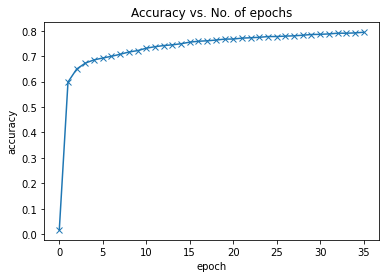

In [27]:
history =  [result0] + history1 + history2 + history3 + history4 + history5 + history6 + history7 
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## Testing with Test dataset

Recreating the test dataset in tensor form.

In [28]:
# Define test dataset
test_dataset = FashionMNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

### Overall loss and accuracy of the model on the test set

In [29]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6821567416191101, 'val_acc': 0.7730468511581421}

Defining a helper function *predict_image*, which returns the predicted label for a single image tensor.

In [30]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Trying out model's prediction a few images

Label: 9 , Predicted: 9


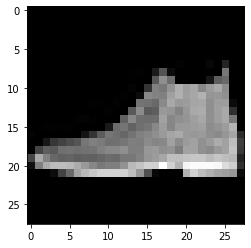

In [31]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 1 , Predicted: 1


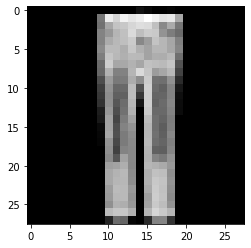

In [32]:
img, label = test_dataset[15]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 8 , Predicted: 8


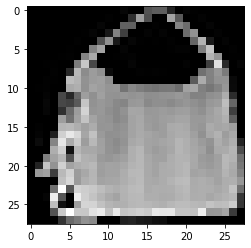

In [33]:
img, label = test_dataset[9500]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 6 , Predicted: 2


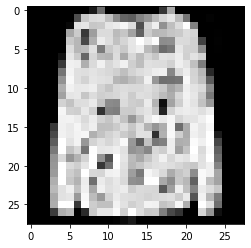

In [34]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

## Final Result

*Accuracy on Test set*: **0.78** | *Over all Loss on Test set*: **0.67**